In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import hilbert

plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams["text.usetex"] = True

[100. 250. 400.]


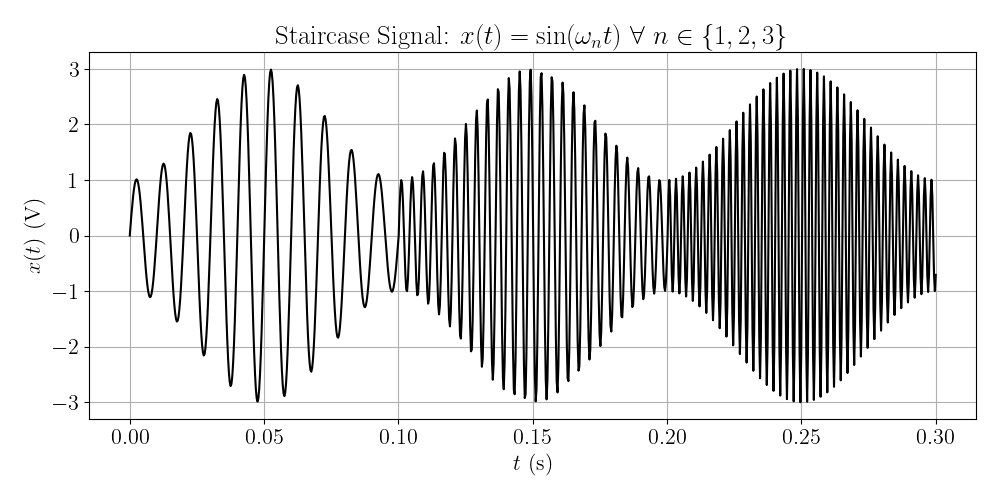

In [2]:
start_freq_hz = 100
end_freq_hz = 400
num_frequencies = 3

frequencies_hz = np.linspace(start_freq_hz, end_freq_hz, num_frequencies)

print(frequencies_hz)

duration_s = 0.1
sampling_rate_hz = 8*end_freq_hz
total_duration_s = duration_s * num_frequencies
time_s = np.linspace(0, duration_s, int(sampling_rate_hz * duration_s), endpoint=False)
total_time_s = np.linspace(0, total_duration_s, int(sampling_rate_hz * total_duration_s))

# Generate sine waves
components = []
for frequency_hz in frequencies_hz:
    component = np.sin(2 * np.pi * frequency_hz * time_s)
    components.append(component)
signal_v = np.concatenate(components)

envelope = (2 + np.sin(2*np.pi*(1/duration_s)*total_time_s - np.pi/2))

signal_v = envelope * signal_v

plt.figure(figsize=(10, 5))
plt.plot(total_time_s, signal_v, color="k")
plt.title(r'Staircase Signal: $x(t) = \sin(\omega_n t)\ \forall\ n \in \{1,2,3\}$')
plt.xlabel(r'$t\ \mathrm{(s)}$')
plt.ylabel(r'$x(t)\ \mathrm{(V)}$')
plt.grid(True)
plt.tight_layout()
plt.show()

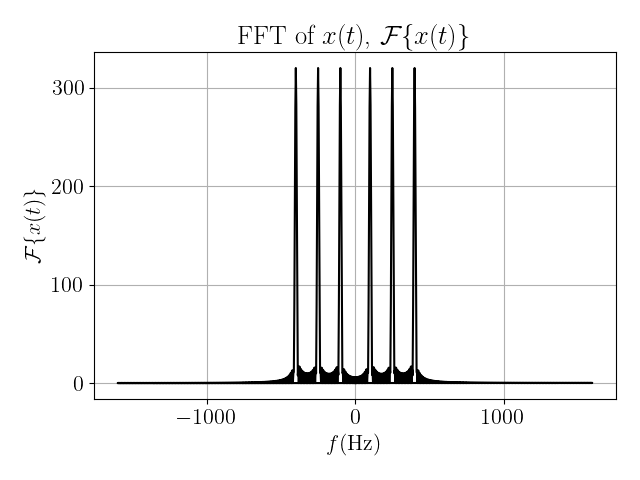

In [3]:
# Compute the FFT
fft_result = np.fft.fft(signal_v)

# Compute the frequencies corresponding to the FFT result
frequencies = np.fft.fftfreq(len(fft_result), 1/sampling_rate_hz)

# Plot the FFT result
plt.figure()
plt.plot(frequencies, np.abs(fft_result), color="k")
plt.title(r'FFT of $x(t)$, $\mathcal{F}\{x(t)\}$')
plt.xlabel(r'$f \mathrm{(Hz)}$')
plt.ylabel(r'$\mathcal{F}\{x(t)\}$')
plt.grid(True)
plt.tight_layout()
plt.show()

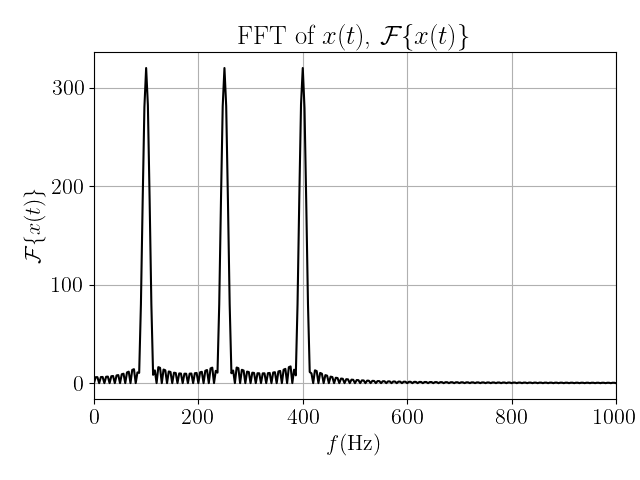

In [7]:
# Compute the FFT
rfft_result = np.fft.rfft(signal_v)

# Compute the frequencies corresponding to the FFT result
rfrequencies = np.fft.rfftfreq(len(total_time_s), 1/sampling_rate_hz)

# Plot the FFT result
plt.figure()
plt.plot(rfrequencies, np.abs(rfft_result), color="k")
plt.title(r'FFT of $x(t)$, $\mathcal{F}\{x(t)\}$')
plt.xlabel(r'$f \mathrm{(Hz)}$')
plt.ylabel(r'$\mathcal{F}\{x(t)\}$')
plt.grid(True)
plt.tight_layout()
plt.xlim([0, 1000])
plt.show()

Text(0.5, 1.0, 'Signal, Envelope, and Frequency')

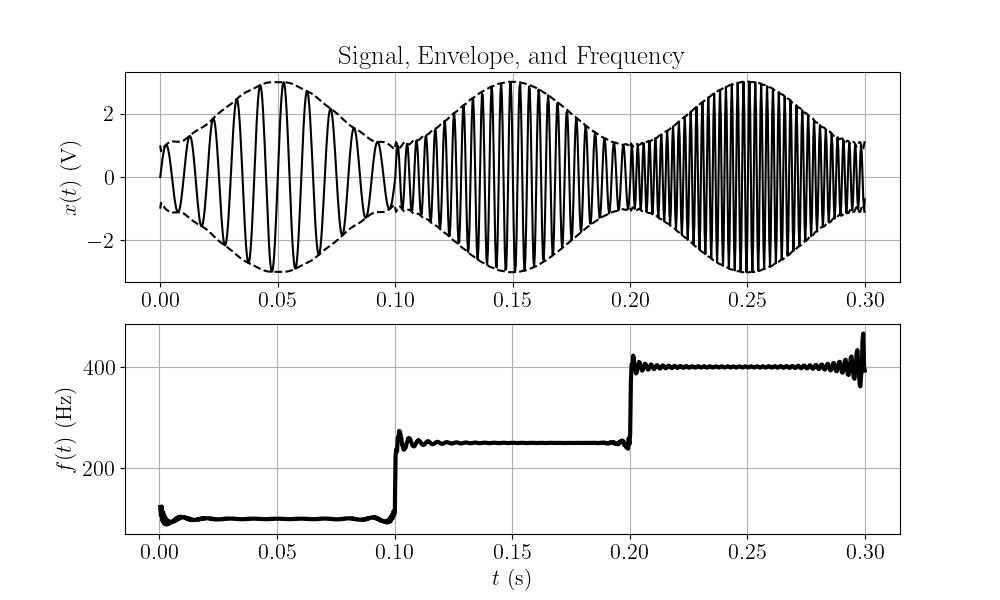

In [8]:
from scipy import signal

analytic_signal = signal.hilbert(signal_v)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) /
                           (2.0*np.pi) * sampling_rate_hz)


fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(10,6))
ax0.plot(total_time_s, signal_v, label='signal', color='k')
ax0.plot(total_time_s, np.mean(signal_v) + amplitude_envelope, label='envelope', color='k', linestyle='--')
ax0.plot(total_time_s, np.mean(signal_v) - amplitude_envelope, label='envelope', color='k', linestyle='--')
ax0.grid(True)
ax0.set_ylabel(r'$x(t)\ \mathrm{(V)}$')
ax1.plot(total_time_s[1:], instantaneous_frequency, color='k', linewidth=3)
ax1.set_xlabel(r"$t\ \mathrm{(s)}$")
ax1.grid()
ax1.set_ylabel(r"$f(t)\ \mathrm{(Hz)}$")
ax0.set_title(r"Signal, Envelope, and Frequency")

(0.0, 800.0)

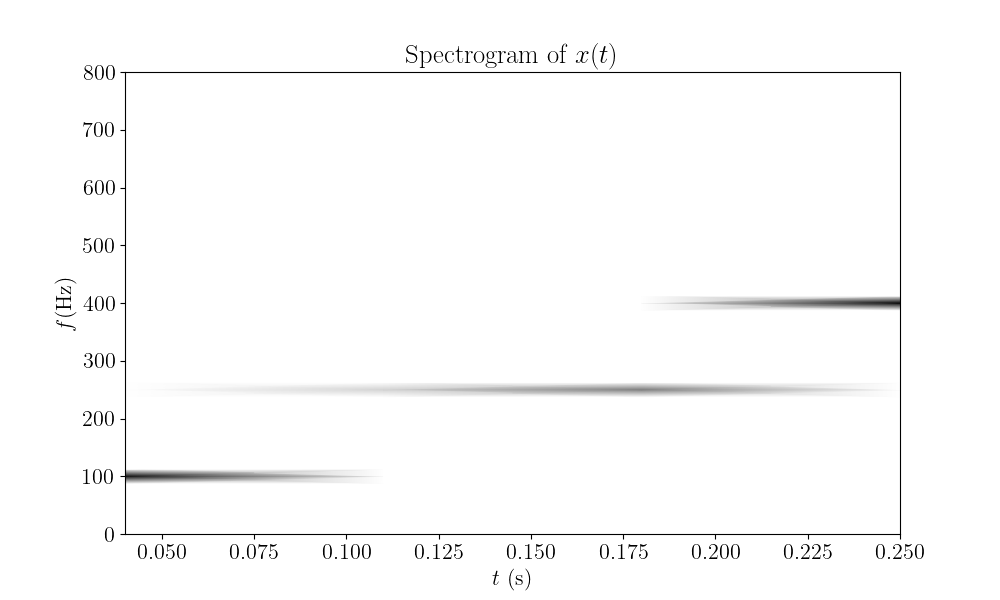

In [20]:
from scipy.fft import fftshift


def normalize(x):
    xmin = np.min(x)
    xmax = np.max(x)
    xnorm = (x - xmin) / (xmax - xmin)
    return xnorm

def normalize_eps_to_one(x, eps=1e-11):
    xnorm = normalize(x)
    x_scaled = xnorm * (1-eps) + eps
    return x_scaled

def convert_power_to_dbfs(power_bins, eps = 1e-11):
    power_bins_normalized = normalize_eps_to_one(power_bins, eps)
    power_bins_dbfs = 10 * np.log10(power_bins_normalized)
    return power_bins_dbfs

dynamic_range_db = 8

f_hz, t_sec, sxx_psd = signal.spectrogram(
    signal_v,
    sampling_rate_hz,
    return_onesided=True,
    mode="psd"
)

sxx_dbfs = convert_power_to_dbfs(sxx_psd)

fh = plt.figure(figsize=(10,6))
plt.pcolormesh(
    t_sec,
    fftshift(f_hz),
    fftshift(sxx_dbfs, axes=0),
    cmap="Greys",
    shading="gouraud",
    vmin=-dynamic_range_db,
    vmax=0
)

plt.title(r'Spectrogram of $x(t)$')
plt.ylabel(r'$f \mathrm{(Hz)}$')
plt.xlabel(r'$t\ \mathrm{(s)}$')
plt.ylim([0, 800])